In [1]:
## 5장에서 본 RNN은 순환경로를 포함하며 과거의 정보를 기억할 수 있었다.
## 구조가 단순하고 구현도 쉽지만 성능이 좋지 못하다.
## 시계열 데이터에서 시간적으로 멀리 떨어진, 장기(Long Term)의존 관계를 잘 학습하지 못한다.

In [2]:
## 요즘에는 단순 RNN 대신 LSTM, GRU이 주로 쓰인다.
## LSTM, GRU에는 게이트(gate)라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다.

# 1. RNN의 문제점

In [3]:
## RNN은 장기 의존 관계 학습이 어려운데, 그 이유는 BPTT에서 기울기 소실 또는 기울기 폭발이 일어나기 때문이다.

### 기울기 소실과 기울기 폭발의 원인

In [4]:
## 길이가 T인 시계열 데이터를 가정하여 T번째 정답 레이블로부터 전해지는 기울기가 어떻게 변하는지 보자.
## RNN 계층에서 시간방향 기울기 전파에만 주목해보자
## 시간 방향 기울기에 주목하면 역전파로 전해지는 기울기는 차례로 'tanh', '+', 'MatMul(행렬 곱)' 연산을 통과한다. 

In [5]:
## '+'의 역전파는 그대로 흘러보낼 뿐이므로 기울기 변화가 없다.
## 'tanh'의 경우 미분하면 1 - tanh**2 이다. 그래프를 보면 y값이 0과 1사이이고 x가 0으로부터 멀어질수록 값이 작아진다.
## 따라서 역전파에서 기울기가 tanh 노드를 지날 때마다 값은 점점 작아진다.
## ReLU를 사용하면 기울기 소실 문제를 줄일 수 있다. 입력 x가 0이상이면 상류의 기울기를 그대로 보내기 때문이다.

## 'MatMul' 노드에서 상류로부터 dh라는 기울기가 흘러온다고 하면, 통과 후 dhW(h).T가 된다. 그리고 같은 계산을 시계열 데이터
## 시간 크기만큼 반복한다. 여기서 주목할 점은 매번 똑같은 가중치 W(h)가 사용된다는 것이다.
## 그러면 어떻게 될까?

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


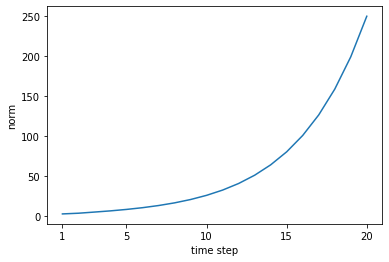

In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):  ## matmul 노드 수(T)만큼 dh 갱신
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N 
    norm_list.append(norm)  ## 각 단계에서 dh의 크기(norm)을 구해 norm_list에 저장
    
print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [11]:
## 결과를 보면 시간에 비례해 지수적으로 기울기가 커지는 것을 알 수 있다.
## 이것이 바로 기울기 폭발(gradient exploding)이다.
## 기울기 폭발이 이러나면 오버플로를 일으켜 NaN(Not a Number)값을 발생시킨다.

[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


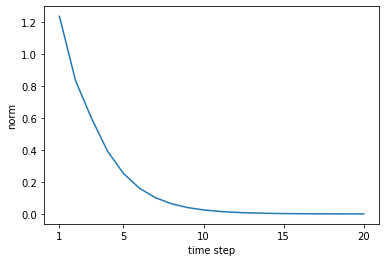

In [12]:
## Wh의 초깃값을 변경한 뒤 다시 실험을 해보자


import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
# Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):  ## matmul 노드 수(T)만큼 dh 갱신
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N 
    norm_list.append(norm)  ## 각 단계에서 dh의 크기(norm)을 구해 norm_list에 저장
    
print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [13]:
## 이번에는 지수적으로 감소한다.
## 이것이 기울기 소실(gradient vanishing)이다. 
## 기울기가 계속 작아지다가 매개변수가 더 이상 갱신되지 않게 되므로 학습이 되지 않는다.

In [28]:
## 이런 지수적인 기울기 변화는 행렬 Wh를 T번 반복해서 곱했기 때문이다. 
## 스칼라에서는 1보다 크면 증가, 1보다 작으면 감소한다.
## 행렬의 경우 특잇값(데이터가 얼마나 퍼져 있는지)이 척도가 된다.
## 특잇값 중 최댓값이 1보다 큰지 여부를 보면 기울기가 어떻게 변할 지 알 수 있다.

In [30]:
## 결국 RNN 신경망에서 'tanh'와 'MatMul' 노드로 인해 기울기 소실과 폭발 문제가 발생한다.

### 기울기 폭발 대책

In [16]:
## 기울기 폭발 대책으로는 전통적인 기법이 있다. 
## 바로 기울기 클리핑(gradients clipping)이라는 기법이다.

## 기울기 크기(norm)이 특정 값(threshold)를 초과하면 기울기를 갱신한다. g = (threshold / norm(g)) * g

In [27]:
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())


before: [9.7795241  5.02751048 8.29001078 0.74037796 4.78915452 0.6227948
 8.84241431 4.45810179 0.68549918]
after: [2.24156114 1.15235384 1.90015034 0.16970176 1.09772036 0.14275057
 2.02676655 1.02183988 0.15712302]


# 2. 기울기 소실과 LSTM

### LSTM의 인터페이스

In [31]:
## LSTM 계층의 인터페이스에는 c라는 경로가 있다
## c를 기억 셀(memory cell)이라 하며, LSTM 전용 기억 메커니즘이다.
## 기억 셀의 특징은 LSTM 계층 내에서만(같은 층에서만) 주고받는다는 것이다.
## 반면, 은닉상태 h는 RNN과 마찬가지로 다른 층으로 출력된다.

### LSTM 계층 조립하기

In [1]:
## LSTM에는 기억 셀 C(t)가 있다. 이 기억 셀에는 시각 t에서의 LSTM의 기억이 저장돼 있는데
## 과거로부터 시각 t까지 필요한 모든 정보가 저장돼 있다

In [2]:
## 기억 셀 c(t)는 3개의 입력(c(t-1), h(t-1), x(t))으로부터 '어떤 계산'을 수행하여 구할 수 있다. 
## 여기서 핵심은 갱신된 c(t)를 사용해 은닉 상태 h(t)를 계산한다는 것이다. h(t) = tanh(c(t))
## 기억 셀 c(t)와 은닉 상태 h(t)의 원소 수는 같다.

In [3]:
## LSTM에서 사용하는 게이트는 '열기/닫기' 뿐 아니라 어느 정도 게이트를 열지 정도 또한 조절할 수 있다.
## 게이트의 열림 상태는 0 ~ 1 사이의 실수로 나타난다.
## 여기서 중요한 것은 게이트를 얼마나 열까라는 것도 데이터로부터 학습한다는 것이다.
## 게이트는 게이트 열림 상태를 제어하기 위해 전용 가중치 매개변수를 이용한다. 게이트 열림상태를 구할 때는 시그모이드 함수를 
## 사용하는데, 시그모이드 함수 출력이 마침 0 ~ 1사이 실수이기 때문이다.

### output 게이트

In [7]:
## output 게이트의 열림 상태는 입력x(t)와 이전 상태h(t-1)로부터 구한다.
## o = sigmoid(x(t)W(x) + h(t-1)W(h) + b)
## h(t) = o * tanh(c(t)) --- 여기서 곱은 원소별 곱이며, 하다마르 곱(Hadamard Product)이라고도 한다.

In [8]:
## tanh의 출력은 -1.0 ~ 1.0의 실수이다. 이 수치를 그 안에 인코딩된 '정보'의 정도를 나타낸다고 볼 수 있다.
## sigmoid 출력은 0 ~ 1의 실수이며, 데이터를 얼마나 통과시킬지를 정하는 비율을 뜻한다.
## 따라서 게이트에서는 sigmoid가 실질적인 정보를 지니는 데이터에는 tanh함수가 쓰인다.

### forget 게이트

In [9]:
## c(t-1)의 기억 중에서 불필요한 정보를 제거하는 역할을 한다.
## f = sigmoid(x(t)W(x) + h(t-1)W(h) + b)
## c(t) = f * c(t-1) --- Hadamard product

### 새로운 기억 셀

In [10]:
## forget게이트를 거치면서 이전 시각의 기억 셀로부터 불필요한 기억을 없앴다.
## 그 다음 바로 현재 상태에서 새로 기억해야 할 정보를 기억 셀에 추가해야 한다.
## g = tanh(x(t)W(x) + h(t-1)W(h) + b)

In [11]:
## (f * c(t-1))+ g = c(t)

### input 게이트

In [12]:
## 마지막으로 g에 게이트를 하나 추가한다.
## input 게이트는 g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다.
## 새로 추가되는 정보를 적절히 취사선택하는 것이 이 게이트의 역할이다.

In [17]:
## i = sigmoid(x(t)W(x) + h(t-1)W(h) + b)

## (f * c(t-1)) + (g * i) = c(t)
## h(t) = o * tanh(c(t))

### LSTM 기울기의 흐름

In [15]:
## 기억 셀 c의 역전파를 주목하면 기울기 소실을 없애주는 원리를 알 수 있다.
## 기억 셀의 역전파에는 '+'와 'x'노드만을 지나게 된다. 
## '+'노드는 기울기를 그대로 흘릴 뿐이므로 기울기 변화가 없다.
## 'x'노드는 RNN에서처럼 행렬곱이 아니라 원소별 곱(아다마르 곱)이고, 매 시각 다른 게이트 값을 이용해 원소별 곱을 한다.
## 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는 것이다.

In [16]:
## 'x'노드의 계산은 forget 게이트가 제어한다. 
## forget 게이트가 중요하지 않다고 판단한 기억 셀의 원소는 기울기가 작아지고
## 중요하다고 판단한 원소는 약화되지 않은 채 전해진다.

# 3. LSTM 구현

In [18]:
## 최초의 한 단계만 처리하는 LSTM 클래스를 구현한 다음 이어서 T개의 단계를 한 번에 처리하는 Time LSTM 클래스를 구현해보자

## f = sigmoid(x(t) * W(x)_f + h(t-1) * W(h)_f + b_f)
## g = tanh(x(t) * W(x)_g + h(t-1) * w(h)_g + b_g)
## i = sigmoid(x(t) * W(x)_i + h(t-1) * W(h)_i + b_i)
## o = sigmoid(x(t) * W(x)_o + h(t-1) * W(h)_o + b_o)
## c(t) = (f * c(t-1)) + (g * i)
## h(t) = o * tanh(c(t))

## LSTM에서 수행하는 계산이다.
## 여기서 주목할 부분은 네 수식에 포함된 아핀 변환(xw(x) + hw(h) + b)이다. 
## 각 식의 가중치를 모아 4개의 식을 단 한 번의 아핀 변환으로 계산할 수 있다.
## x(t)*[W(x)_f, W(x)_g, W(x)_i, W(x)_o] + h(t-1)*[W(h)_f, W(h)_g, W(h)_i, W(h)_o] + [b_f, b_g, b_i, b_o]

In [19]:
## 원래 총 4번의 계산을 한 번으로 마칠 수 있다.
## 행렬 라이브러리는 큰 행렬을 한 번에 계산할 때가 훨씬 빠르다.

In [21]:
class LSTM:
    def __init__(self, Wx, Wh, b): ## 4개분의 가중치와 편향이 담겨 있다.
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None ## 순전파 때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### Time LSTM 구현

In [22]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None: ## stateful = True, self.h = False 일때만 참이다.
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = LSTM(*self.params) # T회 반복되는 LSTM에 리스트의 인수들을 추출하여 LSTM 클래스의 __init__() 메서드에 전달한다.
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
        
    def set_state(self, h, c = None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

# 4. LSTM을 사용한 언어모델

In [23]:
## 앞 장에서 구현한 언어 모델과의 차이점은 LSTM을 사용한다는 점뿐이다.
## 앞의 SimpleRnnlm 클래스와 다르게 여기서 구현할 Rnnlm 클래스는 Time RNN 대신 Time LSTM 계층을 사용한다.

In [24]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


In [25]:
## 이제 이 언어 모델을 사용해 PTB 데이터셋을 학습해보자.
## 이번에는 PTB 데이터셋의 훈련 데이터 전부를 사용해 학습한다.

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.59
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 2908.31
| 에폭 1 |  반복 41 / 1327 | 시간 14[s] | 퍼플렉서티 1228.75
| 에폭 1 |  반복 61 / 1327 | 시간 21[s] | 퍼플렉서티 1009.63
| 에폭 1 |  반복 81 / 1327 | 시간 28[s] | 퍼플렉서티 793.77
| 에폭 1 |  반복 101 / 1327 | 시간 35[s] | 퍼플렉서티 635.68
| 에폭 1 |  반복 121 / 1327 | 시간 42[s] | 퍼플렉서티 641.66
| 에폭 1 |  반복 141 / 1327 | 시간 49[s] | 퍼플렉서티 605.09
| 에폭 1 |  반복 161 / 1327 | 시간 56[s] | 퍼플렉서티 564.05
| 에폭 1 |  반복 181 / 1327 | 시간 63[s] | 퍼플렉서티 595.88
| 에폭 1 |  반복 201 / 1327 | 시간 70[s] | 퍼플렉서티 505.81
| 에폭 1 |  반복 221 / 1327 | 시간 77[s] | 퍼플렉서티 499.37
| 에폭 1 |  반복 241 / 1327 | 시간 83[s] | 퍼플렉서티 450.64
| 에폭 1 |  반복 261 / 1327 | 시간 90[s] | 퍼플렉서티 464.40
| 에폭 1 |  반복 281 / 1327 | 시간 97[s] | 퍼플렉서티 443.63
| 에폭 1 |  반복 301 / 1327 | 시간 104[s] | 퍼플렉서티 390.62
| 에폭 1 |  반복 321 / 1327 | 시간 111[s] | 퍼플렉서티 350.07
| 에폭 1 |  반복 341 / 1327 | 시간 118[s] | 퍼플렉서티 403.87
| 에폭 1 |  반복 361 / 1327 | 시간 125[s] | 퍼플렉서티 404.58
| 에폭 1 |  반복 381 / 1327 | 시간 132[s] | 퍼플렉서티 

| 에폭 3 |  반복 521 / 1327 | 시간 1159[s] | 퍼플렉서티 137.35
| 에폭 3 |  반복 541 / 1327 | 시간 1167[s] | 퍼플렉서티 136.23
| 에폭 3 |  반복 561 / 1327 | 시간 1174[s] | 퍼플렉서티 117.43
| 에폭 3 |  반복 581 / 1327 | 시간 1182[s] | 퍼플렉서티 103.12
| 에폭 3 |  반복 601 / 1327 | 시간 1190[s] | 퍼플렉서티 145.83
| 에폭 3 |  반복 621 / 1327 | 시간 1197[s] | 퍼플렉서티 140.79
| 에폭 3 |  반복 641 / 1327 | 시간 1205[s] | 퍼플렉서티 126.73
| 에폭 3 |  반복 661 / 1327 | 시간 1212[s] | 퍼플렉서티 120.88
| 에폭 3 |  반복 681 / 1327 | 시간 1220[s] | 퍼플렉서티 98.76
| 에폭 3 |  반복 701 / 1327 | 시간 1227[s] | 퍼플렉서티 117.20
| 에폭 3 |  반복 721 / 1327 | 시간 1235[s] | 퍼플렉서티 124.96
| 에폭 3 |  반복 741 / 1327 | 시간 1242[s] | 퍼플렉서티 106.44
| 에폭 3 |  반복 761 / 1327 | 시간 1250[s] | 퍼플렉서티 101.71
| 에폭 3 |  반복 781 / 1327 | 시간 1257[s] | 퍼플렉서티 103.90
| 에폭 3 |  반복 801 / 1327 | 시간 1264[s] | 퍼플렉서티 114.34
| 에폭 3 |  반복 821 / 1327 | 시간 1271[s] | 퍼플렉서티 115.53
| 에폭 3 |  반복 841 / 1327 | 시간 1278[s] | 퍼플렉서티 113.17
| 에폭 3 |  반복 861 / 1327 | 시간 1286[s] | 퍼플렉서티 120.21
| 에폭 3 |  반복 881 / 1327 | 시간 1294[s] | 퍼플렉서티 104.53
| 에폭 3 |  반복 

C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 

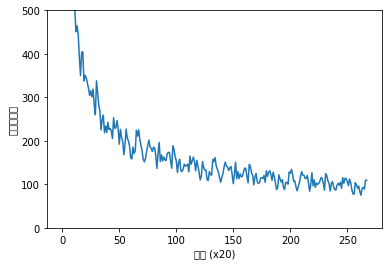

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.08001375233533


In [27]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


In [28]:
## 매 20번째 반복의 퍼플렉서티 값이 출려되었다.
## 그림에서 첫 번째 퍼플렉서티의 값이 10000.59인데, 이는 다음에 나올 수 있는 후보 단어 수를 10000개 정도로 좁혔다는 뜻이다.
## 이번 데이터 셋의 어휘 수가 10000개이므로 아직 아무 것도 학습하지 않은 상태라는 뜻이다.

## 이번 실험에서 총 4에폭(반복으로 환산하면 1327 * 4회)의 학습을 수행했다.
## 퍼플렉서티가 순조롭게 낮아져서 최종적으로 100정도가 되었다.
## 그리고 테스트 데이터로 수행한 최종 평가는 약 135이다.
## 2017년 기준 최첨단 연구에서 PTB 데이터셋의 퍼플렉서티가 60을 밑돌고 있다.
## 우리 모델은 아직 개선할 여지가 많다는 방증이다.
## 다음 절에서 현재의 RNNLM을 한 층 더 개선할 계획이다.

# 5. RNNLM 추가 개선

### LSTM 계층 다층화

In [29]:
## RNNLM으로 정확한 모델을 만들고자 한다면 LSTM 계층을 깊게 쌓아 효과를 볼 수 있다.
## 지금까지 우리는 LSTM 계층을 1층만 사용했지만 2층, 3층 식으로 여러 겹 쌓으면 언어 모델의 정확도가 향상된다.
## 층수는 하이퍼파라미터에 관한 문제이다. 
## 데이터의 양이나 문제의 복잡도에 따라 적절하게 결정해야한다.

### 드롭아웃에 의한 과적합 억제

In [30]:
## LSTM 계층을 다층화하면 시계열 데이터의 복잡한 의존 관계를 학습할 수 있을 것이라 기대할 수 있다.
## 층을 깊게 하면 표현력이 풍부한 모델을 만들 수 있으나 종종 과적합(overfitting)을 일으킨다.
## 불행하게도 RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킨다.

In [31]:
## 과적합을 억제하는 전통적인 방법은 '훈련 데이터 양 늘리기'와 '모델의 복잡도 줄이기'가 있다. 
## 그 외에는 모델의 복잡도에 페널티를 주는 '정규화(Normalization)'도 효과적이다.
## 또 '드롭아웃(Dropout)' 방법도 있다. 
## 이번 절에서는 드롭아웃에 관해 살펴보고 적용해보자

In [32]:
## 드롭아웃 계층을 시계열 방향으로 삽입하는 것은 좋은 방법이 아니다.
## 시계열 방향으로 넣으면 시간이 흐름에 따라 정보가 사라질 수 있다.
## 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적되기 때문이다.

In [33]:
## 그렇다면 드롭아웃 계층을 깊이 방향으로 삽입하는 방법을 생각해보자
## 이렇게 하면 시간 방향으로 아무리 진행해도 정보를 잃지 않는다.
## 드롭아웃이 시간과는 독립적으로 깊이 방향에만 영향을 주기 때문이다.
## 그러나 최근 연구에서 '변형된 드롭아웃'을 제안했고, 시간 방향으로 적용하는 것에 성공했다.
## 변형 드롭아웃은 깊이 방향은 물론 시간 방향도 적용가능하기 때문에 모델 정확도를 한 층 더 향상시킬 수 있다.

## 구조를 보면 같은 계층의 드롭아웃들은 같은 마스크를 공유한다.
## 마스크(mask)란 데이터의 통과/차단을 결정하는 이진 형태의 무작위 패턴이다.
## 같은 계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 고정된다.
## 그 결과 정보를 잃게 되는 방법도 고정되므로, 일반적인 드롭아웃 때와 달리 정보를 지수적으로 잃게 되는 사태는 피할 수 있다.
## 그러나 이 책에서는 일반 드롭아웃을 적용한다.

### 가중치 공유

In [34]:
## 언어 모델을 개선하는 아주 간단한 트릭 중 가중치 공유(weight tying)가 있다.
## 이는 가중치를 공유하는 효과를 준다
## 예 : Embedding 계층과 Softmax 앞의 Affine 계층이 가중치를 공유한다.
## 두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상된다.

In [35]:
## 어휘 수가 V, LSTM 은닉 상태 차원 수가 H라고 하면
## Embedding 계층의 가중치 형상이 V x H가 되고, Affine 계층의 가중치 형상은 H x V가 된다.
## 가중치 공유를 적용하려면 Embedding 계층의 가중치를 전치하여 Affine 계층의 가중치로 설정하기만 하면 된다.

### 개선된 RNNLM 구현

In [36]:
## 개선점 3가지 : 다층화(2층), 드롭아웃 사용(깊이방향), 가중치공유(Embedding & Affine)

In [37]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


In [40]:
## 개선된 RNNLM 학습

# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)


Done
| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 9999.90
| 에폭 1 |  반복 21 / 1327 | 시간 68[s] | 퍼플렉서티 3552.73
| 에폭 1 |  반복 41 / 1327 | 시간 133[s] | 퍼플렉서티 1730.79
| 에폭 1 |  반복 61 / 1327 | 시간 200[s] | 퍼플렉서티 1312.40
| 에폭 1 |  반복 81 / 1327 | 시간 273[s] | 퍼플렉서티 1062.90
| 에폭 1 |  반복 101 / 1327 | 시간 353[s] | 퍼플렉서티 817.14
| 에폭 1 |  반복 121 / 1327 | 시간 422[s] | 퍼플렉서티 750.50
| 에폭 1 |  반복 141 / 1327 | 시간 489[s] | 퍼플렉서티 743.99
| 에폭 1 |  반복 161 / 1327 | 시간 556[s] | 퍼플렉서티 698.02
| 에폭 1 |  반복 181 / 1327 | 시간 624[s] | 퍼플렉서티 684.90
| 에폭 1 |  반복 201 / 1327 | 시간 691[s] | 퍼플렉서티 590.70
| 에폭 1 |  반복 221 / 1327 | 시간 760[s] | 퍼플렉서티 564.81
| 에폭 1 |  반복 241 / 1327 | 시간 829[s] | 퍼플렉서티 508.62


KeyboardInterrupt: 

In [41]:
## 학습 후 테스트 데이터로 얻은 최종 퍼플렉서티는 75정도가 된다.
## 개선 전 135이었음을 생각하면 상당히 개선되었다고 할 수 있다.